### Import required packages

In [42]:
import os
import re
import json
# import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
from collections import Counter
# from factory_func import plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

In [2]:
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, Lambda, LSTM, ConvLSTM2D, TimeDistributed, Masking, Bidirectional
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation, MaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.utils import to_categorical
from keras import optimizers
import keras.backend as K

Using TensorFlow backend.


In [26]:
# import gzip
# from gensim.models import Word2Vec

### 1. ETL & Cleansing  
### 2. Rebalancing (Undersampling)  
### 3. Feature Extraction  
### 4. Model Selection & Evaluation  

## Accuracy Records  
SVM: 45.5172%  
Dense NN: 45.1724%  
CNN: 47.2414%  
LSTM: tbc  
  
*(there might be a ceiling for how much you can improve the accuracy)*

## Data Import

In [3]:
dev_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','dev_sent_emo.csv'))
train_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','train_sent_emo.csv'))
test_raw = pd.read_csv(os.path.join(os.getcwd(), 'data','test_sent_emo.csv'))

In [4]:
dev_raw.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


## Labels Distribution

Text(0.5,1,'testing set')

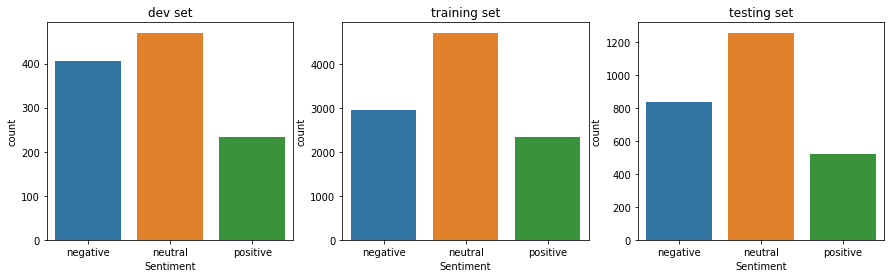

In [5]:
f, axes = plt.subplots(1, 3, figsize=(15,4))
sns.countplot(x='Sentiment', data=dev_raw, ax=axes[0], order=['negative','neutral','positive']).set_title('dev set')
sns.countplot(x='Sentiment', data=train_raw, ax=axes[1], order=['negative','neutral','positive']).set_title('training set')
sns.countplot(x='Sentiment', data=test_raw, ax=axes[2], order=['negative','neutral','positive']).set_title('testing set')

In [7]:
print(Counter(dev_raw.Sentiment))
print(Counter(train_raw.Sentiment))
print(Counter(test_raw.Sentiment))

Counter({'neutral': 470, 'negative': 406, 'positive': 233})
Counter({'neutral': 4710, 'negative': 2945, 'positive': 2334})
Counter({'neutral': 1256, 'negative': 833, 'positive': 521})


In [8]:
dev_raw.Utterance = dev_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
train_raw.Utterance = train_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
test_raw.Utterance = test_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))

Text(0.5,1,'train+test set')

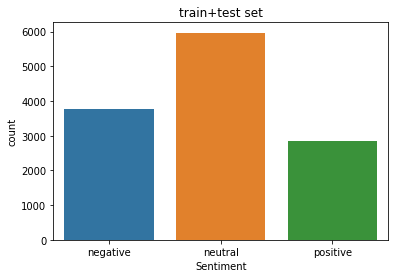

In [9]:
train_raw['source'] = 'train'
test_raw['source'] = 'test'
data_raw = pd.concat([train_raw, test_raw])
data_raw.shape
sns.countplot(x='Sentiment', data=data_raw, order=['negative','neutral','positive']).set_title('train+test set')

## Resampling  
To deal with imbalanced datasets.

In [10]:
count_neutral, count_negative, count_positive = data_raw.Sentiment.value_counts()
print(f'There are {count_negative} negative, {count_neutral} neutral and {count_positive} positive utternaces.')

There are 3778 negative, 5966 neutral and 2855 positive utternaces.


In [11]:
tmp_df_negative = data_raw[data_raw.Sentiment == 'negative']
tmp_df_neutral = data_raw[data_raw.Sentiment == 'neutral']
tmp_df_positive = data_raw[data_raw.Sentiment == 'positive']

tmp_df_negative_undersampled = tmp_df_negative.sample(floor(count_positive*1.1)).reset_index(drop=True)
tmp_df_neutral_undersampled = tmp_df_neutral.sample(floor(count_positive*0.95)).reset_index(drop=True)

In [12]:
data_balanced = pd.concat([tmp_df_negative_undersampled, tmp_df_neutral_undersampled, tmp_df_positive], axis=0)
data_balanced = shuffle(data_balanced)
data_balanced.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,source
2806,2968,"Oh. Thank you. Ohhh, thank you very much. Oh, ...",Monica,joy,positive,297,1,4,20,"00:08:47,109","00:08:53,114",train
712,748,That's great.,Chandler,joy,positive,69,0,1,5,"00:10:00,223","00:10:04,270",train
677,2945,"Sorry I'm late, I was stuck at work. There was...",Ross,neutral,neutral,296,0,1,2,"00:14:38,085","00:14:41,546",train
1547,1631,That all the pieces of my life are falling rig...,Chandler,joy,positive,165,19,4,7,"00:15:10,326","00:15:14,621",train
155,2457,"Yeah, right away Mr. Kaplan.",Rachel,neutral,neutral,247,1,3,11,"0:03:56,581","0:03:57,005",test


There are 3140 negative, 2712 neutral and 2855 positive utternaces.


Text(0.5,1,'rebalanced set')

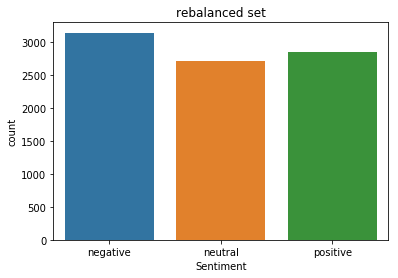

In [13]:
new_c_negative, new_c_positive, new_c_neutral = data_balanced.Sentiment.value_counts()
print(f'There are {new_c_negative} negative, {new_c_neutral} neutral and {new_c_positive} positive utternaces.')
sns.countplot(x='Sentiment', data=data_balanced, order=['negative','neutral','positive']).set_title('rebalanced set')

## Preprocessing (deep learning)

In [14]:
print('The longest utterance contains {} words.'.format(max([len(x.split(' ')) for x in data_balanced.Utterance])))

The longest utterance contains 48 words.


In [15]:
# For sentiment analysis
num_polarities = 3
max_sequence_len = 100

vocabulary_size = 6000
tokenizer = Tokenizer(num_words= vocabulary_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{}~', lower=True)
tokenizer.fit_on_texts(data_balanced.Utterance.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5394 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(data_balanced.Utterance.values)
X = pad_sequences(X, maxlen=max_sequence_len)
print('Shape of data tensor:', X.shape)

# X = tokenizer.texts_to_matrix(data_balanced.Utterance, mode='tfidf')
# print('Shape of data tensor:', X.shape)
# X[0]

Shape of data tensor: (8707, 100)


In [17]:
# Prep target labels for sentiment analysis
y = data_balanced.Sentiment.values
sen_targets, sen_uniques = pd.factorize(y, sort=True)
y = to_categorical(sen_targets, num_polarities)

In [18]:
sen_label_map = dict(zip(list(sen_uniques), range(num_polarities)))
sen_label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [19]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## Preprocessing (supervised learning)  
To avoid naming conflict, the x_train, y_train used in supervised learning will be represented by p_train, q_train

In [36]:
P = data_balanced.Utterance.values
Q = data_balanced.Sentiment.values

tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3))
tfidf.fit(P)
p = tfidf.transform(P)

In [37]:
q, uniques = pd.factorize(Q, sort=True)
label_map = dict(zip(list(uniques), range(num_polarities)))
label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [38]:
svd = TruncatedSVD(n_components=300)
p_svd = svd.fit_transform(p)

In [39]:
p_train, p_test, q_train, q_test = train_test_split(p_svd, q, test_size = 0.33, random_state = 42)

## Factory functions

In [20]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()

## Models  
**Summary on Sentiment Analysis**  
Predicting 3 classes: Positive, Negative & Neutral   
  
**Models ready at disposal:**  
- SVM  
- Random Forest
- Fully connected (Dense only)  
- CNN  
- Transfer learning with Glove + LSTM

**Accuracy records**  
- SVM: 49.37%  
- Random Forest: 48.61%
- Dense: 37.96%
- CNN: 37.54%  
- LSTM (with Glove): 48.3908% (old)

### Support Vector Machine (SVM)

In [34]:
svm = SVC(C=10, kernel='linear', probability=True, gamma='auto_deprecated', random_state=42)

In [ ]:
# param_grid_svm = { 
#     'C': [1,10,100], 'kernel': ['linear', 'rbf']
# }
# clf = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5)
# clf.fit(x_train_tr, y_train)

In [ ]:
# clf.best_estimator_

**Best model by GridSearchCV**  
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,  
decision_function_shape='ovr', degree=3, gamma='auto_deprecated',  
kernel='linear', max_iter=-1, probability=True, random_state=None,  
shrinking=True, tol=0.001, verbose=False)

In [44]:
svm.fit(X=p_train, y=q_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
y_pred_svm = svm.predict(p_test)

In [46]:
f1_score(y_pred=y_pred_svm, y_true=q_test, average="weighted")

0.4785536699324951

In [47]:
svm_accuracy = 100*np.sum(y_pred_svm==q_test)/len(y_pred_svm)
print('Test accuracy: %.4f%%' % svm_accuracy)

Test accuracy: 49.3737%


### Random Forest

In [56]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=4, min_samples_split=4,
                            criterion='gini', max_features='auto')

In [52]:
# param_grid_rf = { 
#     'n_estimators': [1,10,100],
#     'min_samples_split': [2, 4],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }
# clf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5)
# clf.fit(p_train, q_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 10, 100], 'min_samples_split': [2, 4], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
# clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [57]:
rf.fit(X=p_train, y=q_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [58]:
y_pred_rf = rf.predict(p_test)

In [59]:
f1_score(y_pred=y_pred_rf, y_true=q_test, average="weighted")

0.47759736798761787

In [60]:
rf_accuracy = 100*np.sum(y_pred_rf==q_test)/len(y_pred_rf)
print('Test accuracy: %.4f%%' % rf_accuracy)

Test accuracy: 48.6082%


### Keras TF-IDF tokenizer + Neural nets

Neural network won't accept sentences with different dimension(i.e. number of words) as input. By padding the inputs, we decide the maximum length of words in a sentence, then zero pads the rest, if the input length is shorter than the designated length. In the case where it exceeds the maximum length, then it will also truncate either from the beginning or from the end.  
*Ref_1* https://keras.io/preprocessing/sequence/  
*Ref_2* https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74

https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
#### Dense - Fully Connected Layers

__Early Stopping__: Often, the first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better.

We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.

In [44]:
dense_epochs=100
dense_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(),'saved_models','text','dense.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [45]:
def build_dense(num_classes, show=True):
    dense = Sequential()
    dense.add(Dense(32, activation='relu', input_dim=max_sequence_len))
    dense.add(Dropout(0.2))
    dense.add(Dense(64, activation='relu'))
    dense.add(BatchNormalization())
    dense.add(Dense(128, activation='relu'))
    dense.add(BatchNormalization())
    dense.add(Dense(num_classes, activation='softmax'))
    dense.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    if show:
        print(dense.summary())
    return dense

In [46]:
dense = build_dense(num_polarities)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                3232      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total para

The validation_split is a value between 0 and 1 and defines the percentage amount of the training dataset to use for the validation dataset.

In [47]:
dense_history=dense.fit(x_train, y_train, validation_split=0.4, epochs=dense_epochs, callbacks=[dense_checkpts, es], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/100
3499/3499 [==============================] - 2s 450us/step - loss: 1.2590 - acc: 0.3455 - val_loss: 1.1414 - val_acc: 0.3663
Epoch 2/100
3499/3499 [==============================] - 1s 315us/step - loss: 1.1678 - acc: 0.3670 - val_loss: 1.1340 - val_acc: 0.3603
Epoch 3/100
3499/3499 [==============================] - 1s 314us/step - loss: 1.1403 - acc: 0.3718 - val_loss: 1.1307 - val_acc: 0.3569
Epoch 4/100
3499/3499 [==============================] - 1s 312us/step - loss: 1.1265 - acc: 0.3824 - val_loss: 1.1267 - val_acc: 0.3423
Epoch 5/100
3499/3499 [==============================] - 1s 313us/step - loss: 1.1227 - acc: 0.3753 - val_loss: 1.1245 - val_acc: 0.3629
Epoch 6/100
3499/3499 [==============================] - 1s 298us/step - loss: 1.1133 - acc: 0.3721 - val_loss: 1.1675 - val_acc: 0.3552
Epoch 7/100
3499/3499 [==============================] - 1s 306us/step - loss: 1.1158 - acc: 0.3678 - val_loss: 1.1194 - val_acc: 

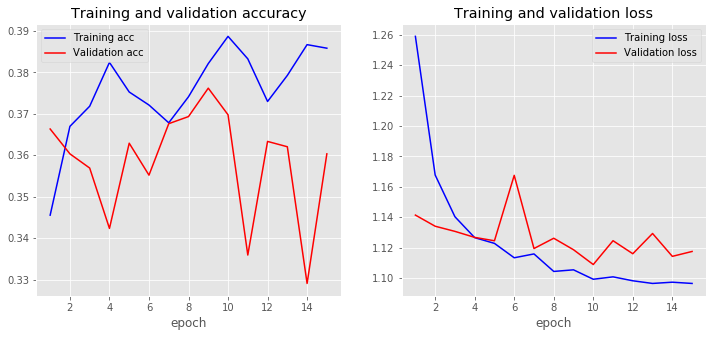

In [48]:
plot_history(dense_history)

Load the best weights saved during training

In [49]:
dense = build_dense(num_polarities, show=False)
dense.load_weights(os.path.join(os.getcwd(),'saved_models','text','dense.weights.best.hdf5'))

In [50]:
y_pred_dense = dense.predict_classes(x_test)
Counter(y_pred_dense)

2874/2874 [==============================] - 0s 81us/step


Counter({0: 1645, 2: 1021, 1: 208})

In [51]:
dense_accuracy = dense.evaluate(x_test, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % dense_accuracy)

2874/2874 [==============================] - 0s 40us/step
Test accuracy: 37.9610%


__About batch_size__  
Advantages of using a batch size < number of all samples:

- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

- Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages of using a batch size < number of all samples:

- The smaller the batch the less accurate the estimate of the gradient will be.

### CNN - Convolutional Layers
**Conv1D:** is generally good for text, whereas Conv2D is good for audio and images where spatial matter;  

**Max pooling:** is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing it’s dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.  

**Batch Normalization:** normalization (shifting inputs to zero-mean and unit variance) is often used as a pre-processing step to make the data comparable across features. This therefore leads to higher learning rate and better speed.  

**Drop out:** Its a regularization functino that reduces/prevents overfitting, by normalizing some pixels to 0.

In [87]:
n_length = x_train.shape[0]
n_features = x_train.shape[1]

x_train_reshaped = x_train.reshape(n_length, n_features, 1)
x_test_reshaped = x_test.reshape(x_test.shape[0], n_features, 1)

In [232]:
cnn_epochs=60
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'saved_models', 'text', 'cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [233]:
def build_CNN(num_classes, show=True):
    cnn = Sequential()
    cnn.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(max_sequence_len,1)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu', kernel_regularizer=l2(0.01)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',kernel_regularizer=l2(0.01)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(GlobalAveragePooling1D())
#     cnn.add(Flatten())
    cnn.add(Dense(128, kernel_regularizer=l2(0.01)))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(Dropout(0.2))
    cnn.add(Dense(num_classes, activation='softmax'))
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    if show:
        print(cnn.summary())
    return cnn

In [234]:
cnn = build_CNN(num_polarities)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_155 (Conv1D)          (None, 100, 16)           48        
_________________________________________________________________
max_pooling1d_151 (MaxPoolin (None, 50, 16)            0         
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 50, 32)            1056      
_________________________________________________________________
max_pooling1d_152 (MaxPoolin (None, 25, 32)            0         
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 25, 64)            4160      
_________________________________________________________________
max_pooling1d_153 (MaxPoolin (None, 12, 64)            0         
_________________________________________________________________
global_average_pooling1d_49  (None, 64)                0         
__________

In [235]:
!rm './saved_models/text/cnn.weights.best.hdf5'
cnn_history=cnn.fit(x_train_reshaped, y_train, validation_split=0.4, epochs=cnn_epochs, callbacks=[cnn_checkpts, es], verbose=1)

rm: cannot remove './saved_models/text/cnn.weights.best.hdf5': No such file or directory
Train on 3499 samples, validate on 2334 samples
Epoch 1/60
3499/3499 [==============================] - 7s 2ms/step - loss: 2.2504 - acc: 0.3481 - val_loss: 1.9005 - val_acc: 0.3740
Epoch 2/60
3499/3499 [==============================] - 1s 396us/step - loss: 1.7574 - acc: 0.3392 - val_loss: 1.5841 - val_acc: 0.3325
Epoch 3/60
3499/3499 [==============================] - 1s 395us/step - loss: 1.5520 - acc: 0.3750 - val_loss: 1.4843 - val_acc: 0.3599
Epoch 4/60
3499/3499 [==============================] - 1s 395us/step - loss: 1.4400 - acc: 0.3572 - val_loss: 1.3546 - val_acc: 0.3830
Epoch 5/60
3499/3499 [==============================] - 1s 397us/step - loss: 1.3575 - acc: 0.3618 - val_loss: 1.3159 - val_acc: 0.3783
Epoch 6/60
3499/3499 [==============================] - 1s 396us/step - loss: 1.2911 - acc: 0.3718 - val_loss: 1.2366 - val_acc: 0.3518
Epoch 7/60
3499/3499 [===========================

Load the best model from save

In [236]:
cnn = build_CNN(num_polarities, show=False)
cnn.load_weights(os.path.join(os.getcwd(),'saved_models','text','cnn.weights.best.hdf5'))

In [237]:
y_pred_cnn = cnn.predict_classes(x_test_reshaped)
Counter(y_pred_cnn)

2874/2874 [==============================] - 2s 698us/step


Counter({2: 1354, 0: 1516, 1: 4})

In [238]:
cnn_accuracy = cnn.evaluate(x_test_reshaped, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % cnn_accuracy)

2874/2874 [==============================] - 2s 637us/step
Test accuracy: 37.5435%


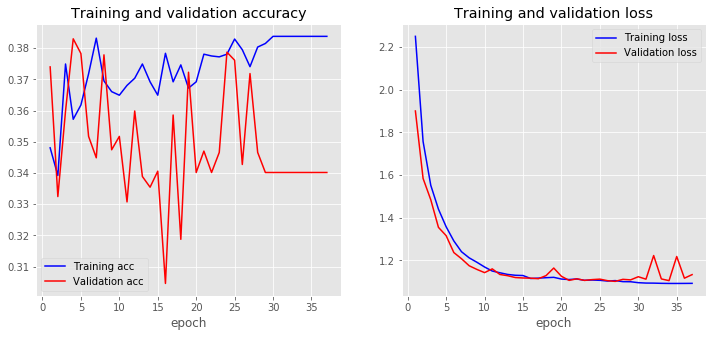

In [239]:
plot_history(cnn_history)

In [8]:
# ENGLISH_STOP_WORDS

### WordEnbedding + LSTM  
- checkpoint: try a pre-trained embedding layer e.g. GloVe Embedding, Word2Vec  
  
Building the embedding from scratch instead of using pre-trained (*this can be a slower approach, but tailors the model to a specific training dataset*)  

Ref_1: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [ ]:
lstm_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'saved_models','text','lstm.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [ ]:
# vocabulary_size = 20000
embedding_size=128
lstm_output_size=64 

def build_LSTM(num_classes)
lstm = Sequential()
lstm.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=6000))
lstm.add(LSTM(units=lstm_output_size, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm.add(Flatten())
lstm.add(Dense(num_classes, activation='sigmoid'))
          
lstm.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
lstm.summary()

In [70]:
lstm.fit(x_train, y_train, validation_split=0.4, epochs=1, callbacks=[lstm_checkpts], verbose=1)

Train on 5993 samples, validate on 3996 samples
Epoch 1/3
5993/5993 [==============================] - 1072s 179ms/step - loss: 1.5608 - acc: 0.4726 - val_loss: 1.5449 - val_acc: 0.4670

Epoch 00001: val_loss improved from inf to 1.54495, saving model to C:\Users\syip\Desktop\DaSci\Nanodegree\ml_nanodegree\capstone/saved_models/lstm.weights.best.hdf5
Epoch 2/3
5993/5993 [==============================] - 1074s 179ms/step - loss: 1.5429 - acc: 0.4746 - val_loss: 1.5357 - val_acc: 0.4670

Epoch 00002: val_loss improved from 1.54495 to 1.53567, saving model to C:\Users\syip\Desktop\DaSci\Nanodegree\ml_nanodegree\capstone/saved_models/lstm.weights.best.hdf5
Epoch 3/3
5993/5993 [==============================] - 1067s 178ms/step - loss: 1.5419 - acc: 0.4746 - val_loss: 1.5396 - val_acc: 0.4670

Epoch 00003: val_loss did not improve from 1.53567


In [72]:
y_pred_lstm = lstm.predict_classes(x_test)
Counter(y_pred_lstm)

Counter({4: 2610})

In [ ]:
lstm_accuracy = 100*np.sum(y_pred_lstm==y_true)/len(y_pred_lstm)
print('Test accuracy: %.4f%%' % lstm_accuracy)

In [37]:
loaded_lstm = load_model('./saved_models/text/emotion/lstm.weights.best.hdf5')

In [38]:
loaded_lstm.predict_classes(x_test[:6])

array([4, 4, 4, 4, 4, 4], dtype=int64)

### WordEmbedding + ConvLSTM

In [66]:
max_features=20000
embedding_size=128
lstm_output_size=32  #70
num_classes=7

conv_lstm = Sequential()
conv_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_size, input_length=20000))
conv_lstm.add(Dropout(0.25))
conv_lstm.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='valid',
                 activation='relu',
                 strides=1))
conv_lstm.add(MaxPooling1D(pool_size=4))
conv_lstm.add(LSTM(units=lstm_output_size, return_sequences=True), activity_regularizer=l1(0.001))
conv_lstm.add(Flatten())
conv_lstm.add(Dense(num_classes, activation='softmax'))

conv_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
conv_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20000, 128)        2560000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 20000, 128)        0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 19996, 64)         41024     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 4999, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4999, 32)          12416     
_________________________________________________________________
flatten_6 (Flatten)          (None, 159968)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 1119783   
Total para

In [ ]:
conv_lstm_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/conv_lstm.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [ ]:
conv_lstm.fit(x_train, y_train, validation_split=0.4, callback=[conv_lstm_checkpts], epochs=1, verbose=1)

In [22]:
y_pred_conv_lstm = conv_lstm.predict_classes(x_test)
Counter(y_pred_conv_lstm)

Counter({4: 2610})

In [25]:
conv_lstm_accuracy = 100*np.sum(y_pred_conv_lstm==y_true)/len(y_true)
print('Test accuracy: %.4f%%' % conv_lstm_accuracy)

Test accuracy: 0.0000%


C:\Users\syip\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


### GloVe

Extract word embeddings from the Glove

In [23]:
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Create a weight matrix

In [24]:
# vocabulary_size=6000

embedding_matrix = np.zeros((vocabulary_size, max_sequence_len))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Glove + LSTM

__Note1:__ Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons.  
About Time Distributed layer: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/  A wrapper to wrap LSTM's output  
  
__Note2:__ To solve the problem of LSTM always predicting the same class even when trained with balanced data, the 'return_sequences' param in the LSTM layer needs to be set to True and add a Flatten layer. In addition, 'return_sequences=True' must be set when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence input

In [26]:
def build_ConvLSTM(num_classes, vocabulary_size=None, max_sequence_len=None, 
                   optimizer=None, use_glove=None, show=True):
    optimizer = optimizer or 'adam'
    use_glove = use_glove or True
    embedding_size=100
    lstm_output_size=128
    vocabulary_size=vocabulary_size or 6000
    max_sequence_len=100
    
    model = Sequential()
    if use_glove:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=max_sequence_len,
                            weights=[embedding_matrix], trainable=False))
    else:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=vocabulary_size))
    model.add(Conv1D(filters=64,
                     kernel_size=2,
                     padding='valid',
                     activation='relu',
                     kernel_regularizer=l2(0.01),
                     strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(units=lstm_output_size, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(64)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(32)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(16)))
    model.add(Dropout(0.2))
#     model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if show:
        print(model.summary())
    return model

In [27]:
glove_epochs=80
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'saved_models','text','glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [28]:
glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
                           optimizer=optimizers.adam(lr=0.001), use_glove=True)
# glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
#                            optimizer='adam', use_glove=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          600000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 99, 64)            12864     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           98816     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 128)           512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 64)            8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 64)            0         
__________

In [29]:
!rm './saved_models/text/glove.weights.best.hdf5'
glove_history=glove.fit(x_train, y_train, validation_split=0.4, epochs=glove_epochs, callbacks=[glove_checkpts, es], verbose=1)

Train on 3499 samples, validate on 2334 samples
Epoch 1/80
3499/3499 [==============================] - 20s 6ms/step - loss: 2.0165 - acc: 0.3475 - val_loss: 1.6831 - val_acc: 0.3329
Epoch 2/80
3499/3499 [==============================] - 16s 5ms/step - loss: 1.5884 - acc: 0.3578 - val_loss: 1.4319 - val_acc: 0.3252
Epoch 3/80
3499/3499 [==============================] - 16s 5ms/step - loss: 1.3759 - acc: 0.3898 - val_loss: 1.3204 - val_acc: 0.3612
Epoch 4/80
3499/3499 [==============================] - 16s 5ms/step - loss: 1.2854 - acc: 0.3510 - val_loss: 1.2434 - val_acc: 0.3869
Epoch 5/80
3499/3499 [==============================] - 16s 4ms/step - loss: 1.2388 - acc: 0.3567 - val_loss: 1.2575 - val_acc: 0.3573
Epoch 6/80
3499/3499 [==============================] - 15s 4ms/step - loss: 1.2066 - acc: 0.3655 - val_loss: 1.2196 - val_acc: 0.3273
Epoch 7/80
3499/3499 [==============================] - 15s 4ms/step - loss: 1.1862 - acc: 0.3681 - val_loss: 1.1666 - val_acc: 0.3573
Epoch 8

In [30]:
glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size,
                           optimizer=optimizers.adam(lr=0.001), use_glove=True, show=False)
glove.load_weights(os.path.join(os.getcwd(),'saved_models','text','glove.weights.best.hdf5'))

In [31]:
y_pred_glove = glove.predict_classes(x_test)
Counter(y_pred_glove)

2874/2874 [==============================] - 4s 1ms/step


Counter({2: 1216, 0: 1658})

In [32]:
glove_accuracy = glove.evaluate(x_test, y_test, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % glove_accuracy)

2874/2874 [==============================] - 1s 448us/step
Test accuracy: 41.6145%


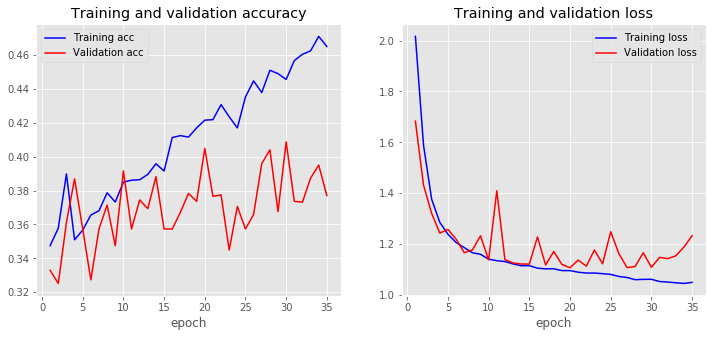

In [33]:
plot_history(glove_history)

### GloVe + LSTM  


In [40]:
sen_glove = build_ConvLSTM(num_classes=num_polarities, vocabulary_size=vocabulary_size, dense_activation='softmax',
                           optimizer=optimizers.adam(lr=0.001), use_glove=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 12000, 100)        1200000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 12000, 100)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11996, 64)         32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2999, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2999, 128)         98816     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2999, 128)         512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2999, 32)          4128      
__________

Note: to use 'callback', one must provide 'validation_split' or 'validation_data'

In [41]:
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
# (Optional) load model
# sen_glove.load_weights(os.path.join(os.getcwd(), 'glove.weights.best.hdf5'))

In [42]:
glove_history = sen_glove.fit(x_train, z_train, validation_split=0.33, epochs=10, 
                              class_weight={0: 1.5, 1: 1., 2: 1.8}, callbacks=[glove_checkpts], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6692 samples, validate on 3297 samples
Epoch 1/10
6692/6692 [==============================] - 1117s 167ms/step - loss: 1.6516 - acc: 0.4274 - val_loss: 1.5440 - val_acc: 0.3649

Epoch 00001: val_loss improved from inf to 1.54401, saving model to /home/ubuntu/glove.weights.best.hdf5
Epoch 2/10
6692/6692 [==============================] - 1093s 163ms/step - loss: 1.4754 - acc: 0.4399 - val_loss: 2.0935 - val_acc: 0.4583

Epoch 00002: val_loss did not improve from 1.54401
Epoch 3/10
6692/6692 [==============================] - 1092s 163ms/step - loss: 1.4607 - acc: 0.4256 - val_loss: 1.8657 - val_acc: 0.4583

Epoch 00003: val_loss did not improve from 1.54401
Epoch 4/10
6692/6692 [==============================] - 1085s 162ms/step - loss: 1.4581 - acc: 0.4162 - val_loss: 1.5282 - val_acc: 0.2323

Epoch 00004: val_loss improved from 1.54401 to 1.52817, saving model to /home/ubuntu/glove.weights.best.hdf5
Epoch 5/10
5888/6692 [======

KeyboardInterrupt: 

In [44]:
glove_accuracy = 100*np.sum(z_pred_glove==z_transf)/len(z_transf)
print('Test accuracy: %.4f%%' % glove_accuracy)

Test accuracy: 48.1226%


In [27]:
# evaluate the model
_, train_acc = sen_glove.evaluate(x_train, z_train, verbose=0)
_, test_acc = sen_glove.evaluate(x_test, z_true, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.472, Test: 0.481


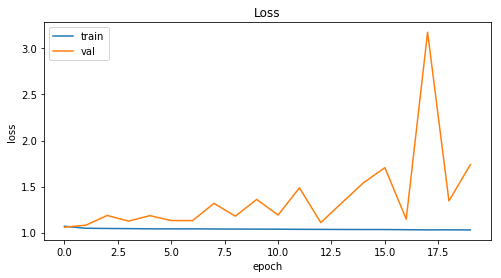

In [23]:
# plot loss during training
plt.figure(figsize=(8,4))
plt.title('Loss')
plt.plot(glove_history.history['loss'], label='train')
plt.plot(glove_history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

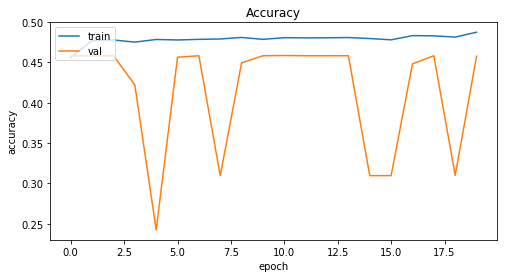

In [24]:
# plot accuracy during training
plt.figure(figsize=(8,4))
plt.title('Accuracy')
plt.plot(glove_history.history['acc'], label='train')
plt.plot(glove_history.history['val_acc'], label='test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### CNN

In [25]:
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/sentiment/cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
sen_cnn = build_CNN(num_polarities)
sen_cnn.fit(x_train_reshaped, z_train, validation_split=0.4, epochs=5, callbacks=[cnn_checkpts], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 20000, 16)         48        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 10000, 16)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10000, 32)         1056      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5000, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5000, 64)          4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 160000)            0         
__________

accuracy: 48%